In [ ]:
# Importação das Bibliotecas
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# carrega e arruma a base
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/spam.csv', encoding="ISO-8859-1")
df.head()
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ["labels", "data"]
df["b_labels"] = df["labels"].map({ "ham": 0, "spam": 1})
y = df["b_labels"].values

In [ ]:
# Separa a base em treino e teste
x_train, x_test, y_train, y_test = train_test_split(df["data"], y, test_size=0.33)

In [ ]:
# Número máximo de palavras para considerar
# São consideradas as mais frequentes, as demais são ignoradas
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
word2index = tokenizer.word_index
V = len(word2index)
print("%s tokens" % V)

7150 tokens


In [ ]:
# Acerta o tamanho das sequências (padding)
data_train = pad_sequences(sequences_train) # usa o tamanho da maior seq.
T = data_train.shape[1] # tamanho da sequência
data_test = pad_sequences(sequences_test, maxlen=T)
print("data_train.shape: ", data_train.shape)
print("data_test.shape: ", data_test.shape)

data_train.shape:  (3733, 162)
data_test.shape:  (1839, 162)


In [ ]:
# Define o modelo
D = 20 # tamanho do embedding, hiperparâmetro que pode ser escolhido
M = 5 # tamanho do hidden state, quantidade de unidades LSTM
i = Input(shape=(T,)) # Entra uma frase inteira
x = Embedding(V+1, D)(i)
x = LSTM(M)(x)
x = Dense(1, activation="sigmoid")(x) # Sigmoide pois só tem 2 valores
model = Model(i, x)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 162)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 162, 20)             │         143,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 5)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,546 (560.73 KB)

 Trainable params: 143,546 (560.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compila e treina o modelo
model.compile(loss="binary_crossentropy", optimizer="adam",
metrics=["accuracy"])
epochs = 5
r = model.fit(data_train, y_train, epochs=epochs, validation_data=(data_test, y_test))

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8389 - loss: 0.5802 - val_accuracy: 0.9201 - val_loss: 0.3381
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9579 - loss: 0.2905 - val_accuracy: 0.9712 - val_loss: 0.1997
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9802 - loss: 0.1763 - val_accuracy: 0.9777 - val_loss: 0.1427
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9928 - loss: 0.1164 - val_accuracy: 0.9810 - val_loss: 0.1122
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9957 - loss: 0.0834 - val_accuracy: 0.9837 - val_loss: 0.0947


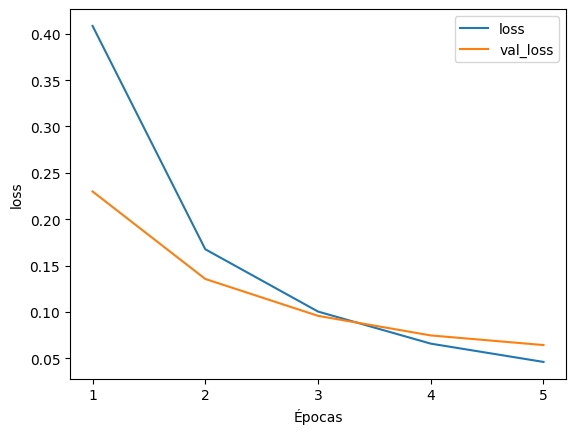

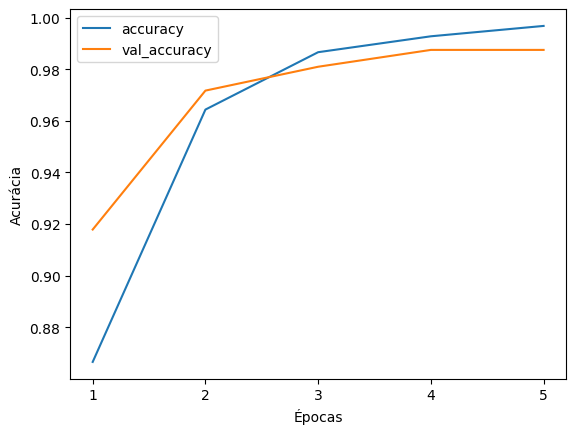

In [ ]:
# Plota função de perda e acurácia
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("loss")
plt.xticks(np.arange(0, epochs, step=1), labels=range(1, epochs+1))
plt.legend()
plt.show()

plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks(np.arange(0, epochs, step=1), labels=range(1, epochs+1))
plt.legend()
plt.show()

In [ ]:
# Efetua a predição de um texto novo
#texto = "Hi, my name is Razer and want to tell you something."
texto = "Is your car dirty? Discover our new product. Free for all. Click the link."
seq_texto = tokenizer.texts_to_sequences([texto]) # Tokeniza
data_texto = pad_sequences(seq_texto, maxlen=T) # Padding
pred = model.predict(data_texto) # Predição
print(pred)
print ("SPAM" if pred >= 0.5 else "OK")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
[[0.53539]]
SPAM
